# Skin Disease Classification

In [2]:
# Emojis for use:
emoji_1 = '⚠️' #caution/error
emoji_2 = '✅' #completed
emoji_3 = '🧼' #cleaning
emoji_4 = '🔽' # downloading

In [1]:
print("yurrrrrrrr")

yurrrrrrrr


In [2]:
#Installing icrawler
!pip install icrawler

  Using cached icrawler-0.6.10-py3-none-any.whl.metadata (6.2 kB)
  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
Using cached icrawler-0.6.10-py3-none-any.whl (36 kB)
Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB 330.3 kB/s eta 0:00:13
   ---------------------------------------- 0.0/4.0 MB 262.6 kB/s eta 0:00:16
   ---------------------------------------- 0.0/4.0 MB 281.8 kB/s eta 0:00:15
    --------------------------------------- 0.1/4.0 MB 262.6 kB/s eta 0:00:16
    --------------------------------------- 0.1/4.0 MB 374.1 kB/s eta 0:00:11
   - -------------------------------------- 0.1/4.0 MB 368.6 kB/s eta 0:00:11
   - -------------------------------------- 0.2/4.0 MB 523.5 kB/s eta 0:00:08
   -- ------------------------------------- 0.2/4.0 MB 593.2 kB/s eta 0:00:0


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import crawler and os
from icrawler.builtin import GoogleImageCrawler
import os

In [4]:
classes_and_keywords = {
    'ringworm':'ringworm skin infection close up human',
    'eczema':'eczema skin',
    'acne':'severe acne face skin close up',
    'psoriasis':'psoriasis skin rash arms back legs',
    'healthy':'clear healthy skin texture close up'
}

base_dir = "skin_disease_dataset"


In [ ]:
# Scraping images from web and storing them in their respective folders
for class_name, keyword in classes_and_keywords.items():
    folder_path = os.path.join(base_dir, class_name)
    os.makedirs(folder_path, exist_ok=True)
    
    print(f'Downloading images for: {class_name}...')
    crawler = GoogleImageCrawler(storage={'root_dir': folder_path})
    crawler.crawl(keyword=keyword, max_num=50)

print(f'All downloads complete sir! {emoji_2}')

#reference: https://icrawler.readthedocs.io/en/latest/

In [ ]:
# re-downloading for psoriasis (not enough was downloaded) --> can be reusable for any other class that wasn't properly downloaded
crawler_ps = GoogleImageCrawler(storage={'root_dir':"skin_disease_dataset/psoriasis"})
crawler_ps.crawl(keyword='psoriasis skin rash arms back legs', max_num=50)
print(f'download done sir! {emoji_2}')

In [7]:
from PIL import Image
# Clean, convert to JPEG, resize to 224x224 
def clean_and_resize_images(base_dir, target_size=(224, 224)):
    for class_folder in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        print(f" Cleaning and resizing: {class_folder}")
        for i, filename in enumerate(os.listdir(class_path)):
            file_path = os.path.join(class_path, filename)
            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")  # Ensure 3 channels
                    img = img.resize(target_size)
                    new_filename = f"{class_folder}_{i+1}.jpg"
                    img.save(os.path.join(class_path, new_filename), "JPEG")

                    if filename != new_filename:
                        os.remove(file_path)  # Delete old if renamed
            except Exception as e:
                print(f"{emoji_1} Skipping {file_path}: {e}")

# Run the cleaner
clean_and_resize_images(base_dir)
print(f"{emoji_2} All images resized, cleaned, and converted to JPEG.")

#reference: https://pillow.readthedocs.io/en/stable/reference/Image.html


 Cleaning and resizing: acne
 Cleaning and resizing: eczema
 Cleaning and resizing: healthy
 Cleaning and resizing: psoriasis
 Cleaning and resizing: ringworm


C:\Users\iamth\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✅ All images resized, cleaned, and converted to JPEG.


In [3]:
# Importing tensorflow and ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Preprocessing & Augmentation

In [5]:
# Define paths
base_dir = "skin_disease_dataset"
img_size = (224, 224)
batch_size = 32
val_split = 0.2  # 20% for validation

In [7]:
# Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=val_split
)


In [8]:
# No augmentation for validation/test, just rescale
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

In [9]:
# Load training images
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)


Found 200 images belonging to 5 classes.


In [10]:
# Load validation images
val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 50 images belonging to 5 classes.


In [11]:

# Class label mapping
print("Class indices:", train_generator.class_indices)

Class indices: {'acne': 0, 'eczema': 1, 'healthy': 2, 'psoriasis': 3, 'ringworm': 4}


### Transfer Learning Script (using MobileNetV2)

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [13]:
# Load pretrained MobileNetV2 without the top classification layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2

In [14]:
# Freeze base model so we only train the head
base_model.trainable = False

In [15]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Regularization to avoid overfitting
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [18]:
# Training model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

C:\Users\iamth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.1812 - loss: 2.1583

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.1792 - loss: 2.1484 - val_accuracy: 0.1600 - val_loss: 1.7257
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.1713 - loss: 1.8341

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1743 - loss: 1.8290 - val_accuracy: 0.1800 - val_loss: 1.6290
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.2311 - loss: 1.7531

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2359 - loss: 1.7444 - val_accuracy: 0.2200 - val_loss: 1.5495
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.3932 - loss: 1.4913

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3884 - loss: 1.4971 - val_accuracy: 0.2800 - val_loss: 1.4654
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3877 - loss: 1.4410

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3830 - loss: 1.4502 - val_accuracy: 0.3200 - val_loss: 1.3955
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.4064 - loss: 1.3396

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4031 - loss: 1.3457 - val_accuracy: 0.3400 - val_loss: 1.3323
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4403 - loss: 1.3187

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4365 - loss: 1.3199 - val_accuracy: 0.4000 - val_loss: 1.2695
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3957 - loss: 1.4273

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3981 - loss: 1.4189 - val_accuracy: 0.4600 - val_loss: 1.2269
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4911 - loss: 1.2546

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4923 - loss: 1.2481 - val_accuracy: 0.4800 - val_loss: 1.1797
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5094 - loss: 1.1755

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5069 - loss: 1.1805 - val_accuracy: 0.5200 - val_loss: 1.1416
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.4815 - loss: 1.1942

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4832 - loss: 1.1899 - val_accuracy: 0.5200 - val_loss: 1.1192
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.5149 - loss: 1.1253

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5137 - loss: 1.1302 - val_accuracy: 0.5200 - val_loss: 1.0941
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.5422 - loss: 1.0497

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5432 - loss: 1.0569 - val_accuracy: 0.5200 - val_loss: 1.0650
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5242 - loss: 1.1295

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5281 - loss: 1.1266 - val_accuracy: 0.5600 - val_loss: 1.0447
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.6140 - loss: 1.0381

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6103 - loss: 1.0412 - val_accuracy: 0.5400 - val_loss: 1.0239
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5866 - loss: 1.0546

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5895 - loss: 1.0444 - val_accuracy: 0.5600 - val_loss: 1.0067
Epoch 17/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.6294 - loss: 0.9365

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6264 - loss: 0.9450 - val_accuracy: 0.5600 - val_loss: 0.9966
Epoch 18/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.6190 - loss: 0.9603

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6154 - loss: 0.9670 - val_accuracy: 0.5600 - val_loss: 0.9900
Epoch 19/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.5724 - loss: 0.9615

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5740 - loss: 0.9624 - val_accuracy: 0.6000 - val_loss: 0.9738
Epoch 20/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.5998 - loss: 0.9422

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5998 - loss: 0.9463 - val_accuracy: 0.6200 - val_loss: 0.9645
Epoch 21/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.6278 - loss: 0.9562

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6268 - loss: 0.9594 - val_accuracy: 0.6400 - val_loss: 0.9546
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6158 - loss: 0.9524

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6195 - loss: 0.9461 - val_accuracy: 0.6400 - val_loss: 0.9481
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.5595 - loss: 0.9691

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5665 - loss: 0.9658 - val_accuracy: 0.6400 - val_loss: 0.9432
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.5977 - loss: 0.9602

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6024 - loss: 0.9528 - val_accuracy: 0.6200 - val_loss: 0.9400
Epoch 25/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7547 - loss: 0.7730

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7522 - loss: 0.7789 - val_accuracy: 0.6200 - val_loss: 0.9297
Epoch 26/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.6484 - loss: 0.9085

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6474 - loss: 0.9077 - val_accuracy: 0.6200 - val_loss: 0.9242
Epoch 27/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7299 - loss: 0.8702

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7293 - loss: 0.8636 - val_accuracy: 0.6200 - val_loss: 0.9166
Epoch 28/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.6757 - loss: 0.7854

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6725 - loss: 0.7931 - val_accuracy: 0.6200 - val_loss: 0.9078
Epoch 29/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.7020 - loss: 0.7425

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6999 - loss: 0.7441 - val_accuracy: 0.6200 - val_loss: 0.9061
Epoch 30/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.6574 - loss: 0.7779

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6596 - loss: 0.7758 - val_accuracy: 0.6200 - val_loss: 0.9016


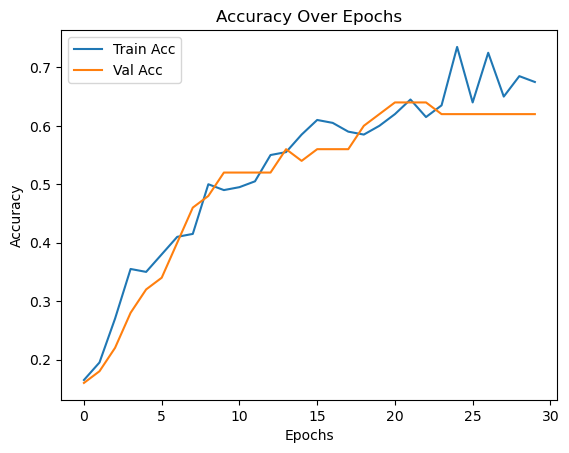

In [19]:
# Plotting training results
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
              precision    recall  f1-score   support

        acne       0.12      0.10      0.11        10
      eczema       0.29      0.20      0.24        10
     healthy       0.18      0.20      0.19        10
   psoriasis       0.27      0.30      0.29        10
    ringworm       0.31      0.40      0.35        10

    accuracy                           0.24        50
   macro avg       0.23      0.24      0.23        50
weighted avg       0.23      0.24      0.23        50



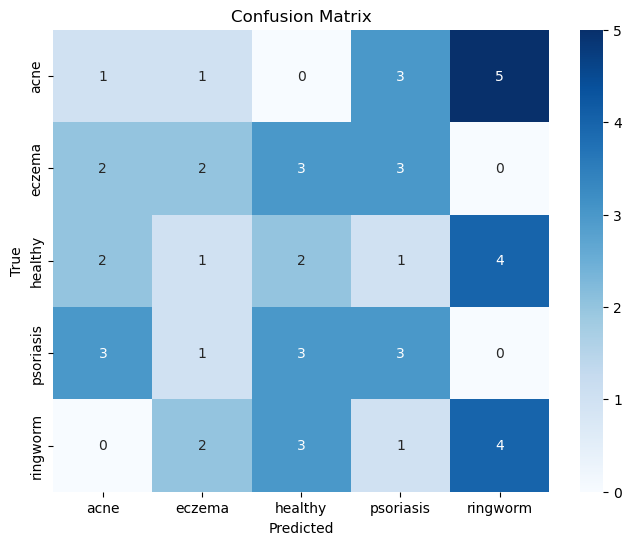

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation data
val_generator.reset()
pred_probs = model.predict(val_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Fine-tuning Model

In [22]:
# Step 1: Unfreeze last few layers of the base model
base_model.trainable = True

In [23]:
# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [24]:
# Step 2: Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Step 3: Retrain the model
fine_tune_epochs = 15  # We'll train for a few more epochs
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    callbacks=callbacks  # Same early stopping + checkpoint
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6011 - loss: 1.0811   

7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5966 - loss: 1.0833 - val_accuracy: 0.6600 - val_loss: 0.8944
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6168 - loss: 1.0571   

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6172 - loss: 1.0582 - val_accuracy: 0.6600 - val_loss: 0.8890
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5850 - loss: 1.0735

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5906 - loss: 1.0659 - val_accuracy: 0.6400 - val_loss: 0.8846
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.6418 - loss: 0.9973

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6366 - loss: 1.0063 - val_accuracy: 0.6400 - val_loss: 0.8789
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6543 - loss: 0.9590   

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6569 - loss: 0.9575 - val_accuracy: 0.6200 - val_loss: 0.8732
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6121 - loss: 1.0252   

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6156 - loss: 1.0197 - val_accuracy: 0.6000 - val_loss: 0.8687
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6461 - loss: 0.8349   

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6504 - loss: 0.8363 - val_accuracy: 0.6200 - val_loss: 0.8658
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6966 - loss: 0.9194  

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6933 - loss: 0.9165 - val_accuracy: 0.5800 - val_loss: 0.8635
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6680 - loss: 0.9041

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6651 - loss: 0.9075 - val_accuracy: 0.6000 - val_loss: 0.8606
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7115 - loss: 0.8578  

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7076 - loss: 0.8573 - val_accuracy: 0.5800 - val_loss: 0.8580
Epoch 11/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.7014 - loss: 0.8581

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7044 - loss: 0.8539 - val_accuracy: 0.5800 - val_loss: 0.8554
Epoch 12/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.7393 - loss: 0.7610

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7369 - loss: 0.7654 - val_accuracy: 0.5800 - val_loss: 0.8529
Epoch 13/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7232 - loss: 0.8436  

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7241 - loss: 0.8422 - val_accuracy: 0.6000 - val_loss: 0.8501
Epoch 14/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7516 - loss: 0.7482  

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7470 - loss: 0.7535 - val_accuracy: 0.5800 - val_loss: 0.8481
Epoch 15/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7236 - loss: 0.8207

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7251 - loss: 0.8151 - val_accuracy: 0.6000 - val_loss: 0.8471


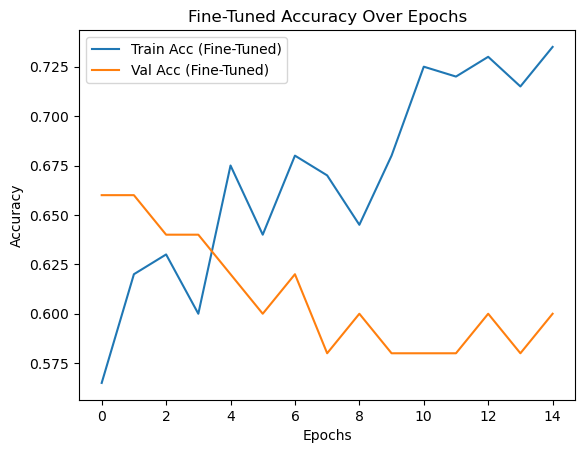

In [26]:
# Step 4: Plot the updated training curves
plt.plot(history_fine.history['accuracy'], label='Train Acc (Fine-Tuned)')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc (Fine-Tuned)')
plt.title('Fine-Tuned Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [29]:
history_more = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.7496 - loss: 0.8118

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7503 - loss: 0.8093 - val_accuracy: 0.6000 - val_loss: 0.8450
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7570 - loss: 0.6977   

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7567 - loss: 0.6976 - val_accuracy: 0.6200 - val_loss: 0.8435
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.6672 - loss: 0.8157

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6719 - loss: 0.8116 - val_accuracy: 0.6400 - val_loss: 0.8417
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7126 - loss: 0.7516

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7123 - loss: 0.7518 - val_accuracy: 0.6400 - val_loss: 0.8409
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7742 - loss: 0.7322   

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7737 - loss: 0.7304 - val_accuracy: 0.6200 - val_loss: 0.8397
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7639 - loss: 0.6742

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7597 - loss: 0.6812 - val_accuracy: 0.6200 - val_loss: 0.8380
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7295 - loss: 0.7309

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7389 - loss: 0.7202 - val_accuracy: 0.6400 - val_loss: 0.8364
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.8046 - loss: 0.6695

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8034 - loss: 0.6702 - val_accuracy: 0.6400 - val_loss: 0.8350
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8101 - loss: 0.6245 - val_accuracy: 0.6400 - val_loss: 0.8355
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8451 - loss: 0.5860 - val_accuracy: 0.6600 - val_loss: 0.8358


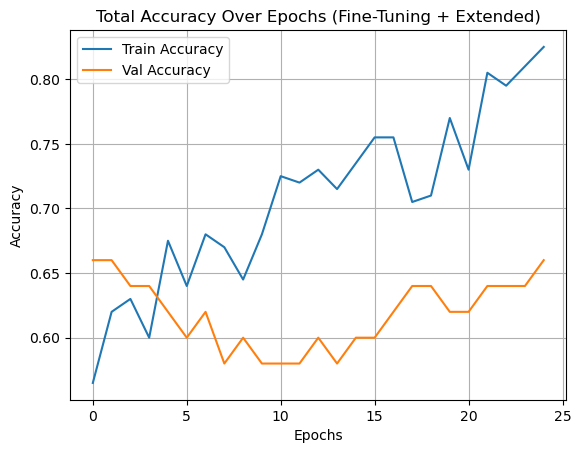

In [30]:
import matplotlib.pyplot as plt

# Combine history from fine-tune + more epochs
full_acc = history_fine.history['accuracy'] + history_more.history['accuracy']
full_val_acc = history_fine.history['val_accuracy'] + history_more.history['val_accuracy']

# Plot
plt.plot(full_acc, label='Train Accuracy')
plt.plot(full_val_acc, label='Val Accuracy')
plt.title('Total Accuracy Over Epochs (Fine-Tuning + Extended)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
📄 Classification Report:
              precision    recall  f1-score   support

        acne       0.12      0.10      0.11        10
      eczema       0.18      0.20      0.19        10
     healthy       0.23      0.30      0.26        10
   psoriasis       0.11      0.10      0.11        10
    ringworm       0.11      0.10      0.11        10

    accuracy                           0.16        50
   macro avg       0.15      0.16      0.15        50
weighted avg       0.15      0.16      0.15        50



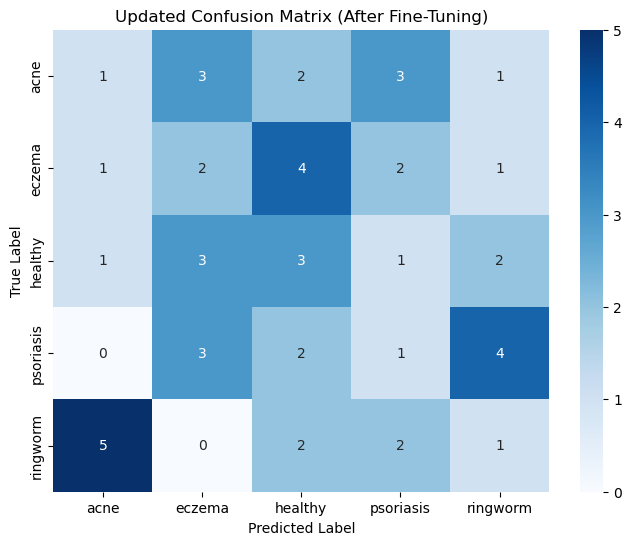

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation data
val_generator.reset()
pred_probs = model.predict(val_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("📄 Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix (After Fine-Tuning)")
plt.show()


In [31]:
model.save("skin_classifier_model_2.keras")


### Improving Model with more Dataset (IMD Process)

In [1]:
from icrawler.builtin import GoogleImageCrawler
import os

In [ ]:
# since large amount of image datset will be downloaded, sequential coding would be most efficient with Google Image Crawler

In [3]:
def download_images(keyword,file_path,num=100):
    crawler = GoogleImageCrawler(storage={'root_dir':file_path})
    crawler.crawl(keyword=keyword, max_num=num)

In [ ]:
download_images('acne on black skin', "raw_new_images/acne", 70)

In [ ]:
download_images('eczemaon black skin',"raw_new_images/eczema",70)

In [ ]:
download_images('psoriasis on black skin', "raw_new_images/psoriasis", 70)

In [ ]:
download_images('ringworm on black skin', "raw_new_images/ringworm", 70)

In [ ]:
download_images('healthy black skin close up', "raw_new_images/healthy", 70)

In [4]:
from PIL import Image
import shutil

In [5]:
# Updated paths
new_data_dir = "raw_new_images"  # <-- new image folder with 70 images per class
final_data_dir = "skin_disease_dataset"  # <-- existing dataset folder
target_size = (224, 224)

In [6]:
# Process new images and move them to the main dataset
for class_name in os.listdir(new_data_dir):
    class_folder = os.path.join(new_data_dir, class_name)
    save_folder = os.path.join(final_data_dir, class_name)
    os.makedirs(save_folder, exist_ok=True)

    print(f"{emoji_3} Cleaning: {class_name}")
    for filename in os.listdir(class_folder):
        file_path = os.path.join(class_folder, filename)
        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB")  # remove alpha channel if any
                img = img.resize(target_size)
                save_name = filename.split('.')[0] + ".jpg"
                save_path = os.path.join(save_folder, save_name)
                img.save(save_path, "JPEG")
        except Exception as e:
            print(f"{emoji_1} Skipping {file_path}: {e}")

🧼 Cleaning: acne
🧼 Cleaning: eczema
🧼 Cleaning: healthy
🧼 Cleaning: psoriasis
🧼 Cleaning: ringworm


In [3]:
## RESIZING IMAGES IN DATASET
import os
from PIL import Image

# Set the path to your dataset folder
dataset_path = 'skin_disease_dataset'
target_size = (224, 224)

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    
    if not os.path.isdir(class_folder):
        continue

    print(f"📂 Processing: {class_name}")

    for filename in os.listdir(class_folder):
        if "resize" in filename.lower():
            file_path = os.path.join(class_folder, filename)
            
            try:
                with Image.open(file_path) as img:
                    # Convert to RGB (JPEG can't handle alpha channels)
                    img = img.convert('RGB')
                    img = img.resize(target_size)

                    # Save as JPEG (overwrite or replace with .jpg)
                    new_filename = os.path.splitext(filename)[0] + ".jpg"
                    new_path = os.path.join(class_folder, new_filename)
                    img.save(new_path, "JPEG")

                    # Optionally delete the old file if different format
                    if file_path != new_path:
                        os.remove(file_path)

                    print(f"{emoji_2} Converted: {filename} -> {new_filename}")

            except Exception as e:
                print(f"{emoji_1} Skipped {filename}: {e}")


📂 Processing: acne
✅ Converted: 000057_resize.jpg -> 000057_resize.jpg
✅ Converted: acne_16_resize.jpg -> acne_16_resize.jpg
✅ Converted: acne_24_resize.jpg -> acne_24_resize.jpg
✅ Converted: acne_33_resize.jpg -> acne_33_resize.jpg
✅ Converted: acne_40_resize.jpg -> acne_40_resize.jpg
✅ Converted: acne_resize_1.jpg -> acne_resize_1.jpg
✅ Converted: acne_resize_10.jpg -> acne_resize_10.jpg
✅ Converted: acne_resize_11.jpg -> acne_resize_11.jpg
✅ Converted: acne_resize_12.jpg -> acne_resize_12.jpg
✅ Converted: acne_resize_13.jpg -> acne_resize_13.jpg
✅ Converted: acne_resize_14.jpg -> acne_resize_14.jpg
✅ Converted: acne_resize_15.jpg -> acne_resize_15.jpg
✅ Converted: acne_resize_16.jpg -> acne_resize_16.jpg
✅ Converted: acne_resize_17.jpg -> acne_resize_17.jpg
✅ Converted: acne_resize_18.jpg -> acne_resize_18.jpg
✅ Converted: acne_resize_19.jpg -> acne_resize_19.jpg
✅ Converted: acne_resize_2.jpg -> acne_resize_2.jpg
✅ Converted: acne_resize_20.jpg -> acne_resize_20.jpg
✅ Converted: ac